# Section 1: Setting Up

### 1.1 Loading Libraries

In [256]:
#!pip install pandas numpy matplotlib seaborn scikit-learn xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

### 1.2 Importing Data
The dataset was imported from the specified SQLite database (agri.db) using a direct SQL query. This dataset contains 57,489 rows and 15 columns, representing various plant growth and environmental factors. Upon initial inspection, some numerical values appear to be stored as objects (strings) instead of numeric types. This suggests that data cleaning may be required to ensure proper numerical analysis later.

In [257]:
conn = sqlite3.connect("data/agri.db")
df = pd.read_sql("SELECT * FROM farm_data;", conn)
conn.close() 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

# Section 2: Cleaning Data

### 2.1 Cleaning Categorical Variables
To understand the categorical variables in the dataset: **System Location Code, Previous Cycle Plant Type, Plant Type, and Plant Stage**, a summary table was generated to display the number of unique values for each variable and provide a preview of their distinct categories.  

The table revealed that **Plant Type** and **Plant Stage** contained inconsistencies in capitalization, with some values in uppercase and others in lowercase. To ensure uniformity and prevent duplicate categories due to case differences, all categorical values were converted to lowercase.

In [258]:
# Define categorical columns
cat_cols = ["System Location Code", "Previous Cycle Plant Type", "Plant Type", "Plant Stage"]

# Create a summary table for unique values
cat_summary = pd.DataFrame({
    "Variable Name": cat_cols,
    "Unique Value Count": [df[col].nunique() for col in cat_cols],
    "Unique Values": [", ".join(map(str, df[col].unique()))[:100] + "..." if len(", ".join(map(str, df[col].unique()))) > 100 else ", ".join(map(str, df[col].unique())) for col in cat_cols]
})

# Print the summary table
print("Rerun this chunk to see the changes!\n")
pd.set_option('display.max_colwidth', None)  # Prevents truncation in Pandas display
print(cat_summary.to_string(index=False))  # Ensures full table prints inline

# Convert categorical columns to lowercase
df[cat_cols] = df[cat_cols].apply(lambda x: x.str.lower())

Rerun this chunk to see the changes!

            Variable Name  Unique Value Count                                                                                           Unique Values
     System Location Code                   7                                                  Zone_D, Zone_G, Zone_F, Zone_B, Zone_C, Zone_A, Zone_E
Previous Cycle Plant Type                   4                                                    Herbs, Vine Crops, Leafy Greens, Fruiting Vegetables
               Plant Type                  12 Vine Crops, VINE CROPS, herbs, fruiting vegetables, LEAFY GREENS, FRUITING VEGETABLES, Leafy Greens,...
              Plant Stage                   9          Maturity, Vegetative, maturity, seedling, MATURITY, Seedling, SEEDLING, VEGETATIVE, vegetative


### 2.2 Cleaning Quantitative Variables
The dataset contains several quantitative variables, including sensor readings for temperature, humidity, light intensity, CO₂ levels, and nutrient concentrations. To ensure consistency, all known non-numeric placeholders such as `"None"`, `"nan"`, `""`, and `"N/A"` are replaced with `NA`. Additionally, numerical values that contain `"ppm"` as a suffix were stripped and converted to float format for proper analysis.  

A summary table is generated to display the **minimum and maximum values** for each quantitative variable, along with the **proportion of negative values** in each column. The table revealed that the proportion of negative values is relatively small across all variables, suggesting that these values were likely anomalies. Given their low occurrence and the fact that negative values are not meaningful in sensor readings, they are replaced with `NA` to prevent skewing the analysis.  

In [259]:
# Define quantitative columns
quant_cols = [
    "Temperature Sensor (°C)", "Humidity Sensor (%)", "Light Intensity Sensor (lux)", "Water Level Sensor (mm)",
    "CO2 Sensor (ppm)", "EC Sensor (dS/m)", "O2 Sensor (ppm)", "pH Sensor",
    "Nutrient N Sensor (ppm)", "Nutrient P Sensor (ppm)", "Nutrient K Sensor (ppm)"
]

# Convert 'None' strings and other non-numeric placeholders to NA
df[quant_cols] = df[quant_cols].replace(["None", "nan", "", "N/A"], pd.NA)

# Remove suffixes and convert to numeric
df[quant_cols] = df[quant_cols].astype(str).replace(r"\s*ppm", "", regex=True)
df[quant_cols] = df[quant_cols].apply(pd.to_numeric, errors="coerce")

# Create a summary table showing min and max values to highlight negative values
quant_summary = pd.DataFrame({
    "Variable Name": quant_cols,
    "Min Value": df[quant_cols].min().values,
    "Max Value": df[quant_cols].max().values,
    "Proportion Negative": (df[quant_cols] < 0).mean().values
})
print("Rerun this chunk to see the changes!\n")
print(quant_summary.to_string(index=False))

# Replace negative values with NA
df[quant_cols] = df[quant_cols].map(lambda x: pd.NA if x < 0 else x)

Rerun this chunk to see the changes!

               Variable Name   Min Value   Max Value  Proportion Negative
     Temperature Sensor (°C)  -28.570000   28.750000             0.021778
         Humidity Sensor (%)   59.220000   81.140000             0.000000
Light Intensity Sensor (lux) -799.000000  800.000000             0.024092
     Water Level Sensor (mm)   10.001955   39.998717             0.000000
            CO2 Sensor (ppm)  799.000000 1500.000000             0.000000
            EC Sensor (dS/m)   -0.250000    3.440000             0.000244
             O2 Sensor (ppm)    3.000000   11.000000             0.000000
                   pH Sensor    3.800000    7.800000             0.000000
     Nutrient N Sensor (ppm)   49.000000  250.000000             0.000000
     Nutrient P Sensor (ppm)   19.000000   80.000000             0.000000
     Nutrient K Sensor (ppm)   99.000000  350.000000             0.000000


Missing values were only present in **quantitative columns**, with no missing data in categorical variables. A bar chart was generated to visualize the proportion of missing values across all quantitative features.  

The **Humidity Sensor (%)** had the highest proportion of missing values, accounting for **about two-thirds of the data**. Given the high amount of missing data, median imputation may not be the best approach, and removing this feature entirely could be considered.  

For the remaining quantitative variables with missing values, the proportion is **less than 20%**, making **median imputation a reasonable option** to preserve the data while ensuring consistency in further analysis and modeling.  

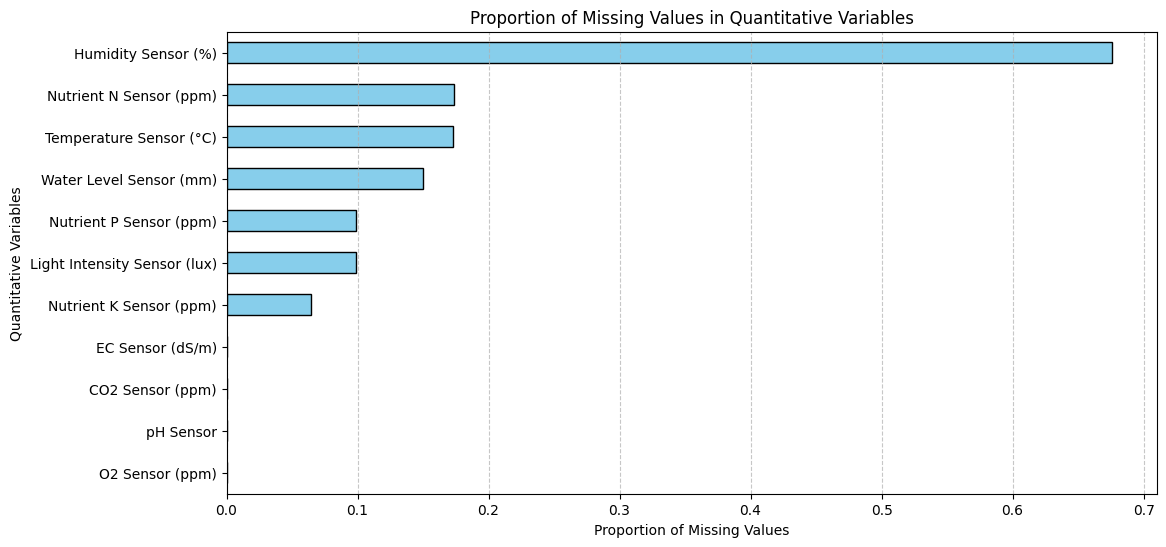

In [260]:
# Barplot of proportion of missing values in quantitative columns
missing_values = df[quant_cols].isna().mean().sort_values(ascending=True)
plt.figure(figsize=(12, 6))
missing_values.plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("Proportion of Missing Values")
plt.ylabel("Quantitative Variables")
plt.title("Proportion of Missing Values in Quantitative Variables")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Section 3: Univariate Analysis

### 3.1 Proportion in Categorical Variables
Pie charts were used to visualize the distribution of categories within each categorical variable: **System Location Code, Previous Cycle Plant Type, Plant Type, and Plant Stage**. Each category within these variables is well-represented, with no extreme class imbalances observed. This suggests that all categorical variables provide meaningful diversity in the dataset.  

Since the distribution across categories is relatively uniform, there is no immediate need to bin or consolidate categorical variables when preparing the dataset for modeling. Instead, these variables can be used as-is, with one-hot encoding, to retain their full predictive potential.  

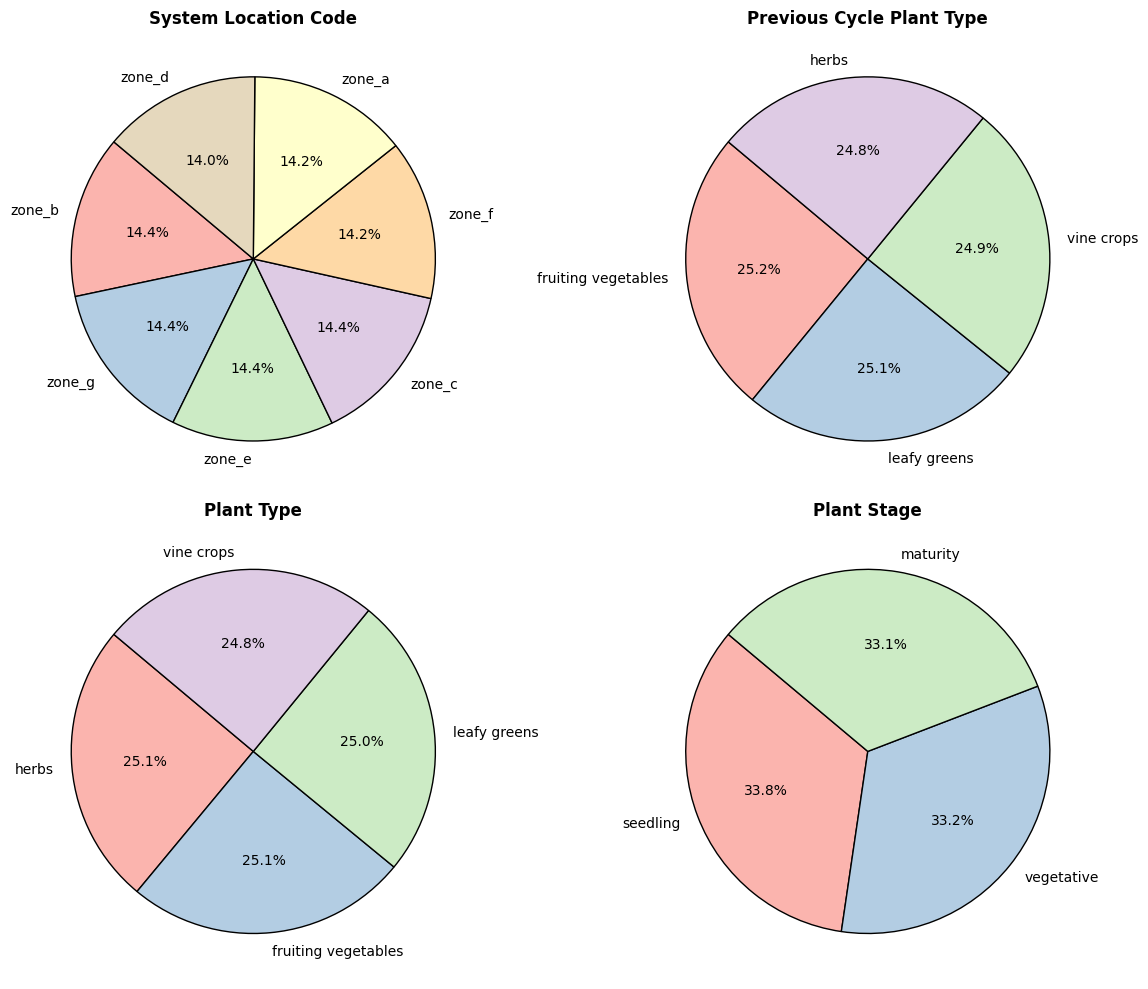

In [261]:
# Pie charts for each categorical variable
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
colors = plt.cm.Pastel1.colors
for i, col in enumerate(cat_cols):
    value_counts = df[col].value_counts()
    wedges, texts, autotexts = axes[i].pie(
        value_counts, labels=value_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, wedgeprops={"edgecolor": "black"}
    )
    for text in texts + autotexts:
        text.set_fontsize(10)
    axes[i].set_title(col, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

### 3.2 Distribution of Quantitative Variables
Violin plots were used to examine the distribution of each quantitative variable. The plots show **no significant skew**, indicating that **transformations are not necessary** to correct distributional imbalances. The variables appear to be naturally distributed without extreme tailing, meaning they can be used in their current form for modeling.  

One notable observation is that **O₂ Sensor (ppm) appears to exhibit a multimodal distribution**. However, this is expected as **oxygen levels are measured in discrete values**, rather than being continuously variable. Therefore, this does not indicate an underlying issue with the data and does not require special handling.  

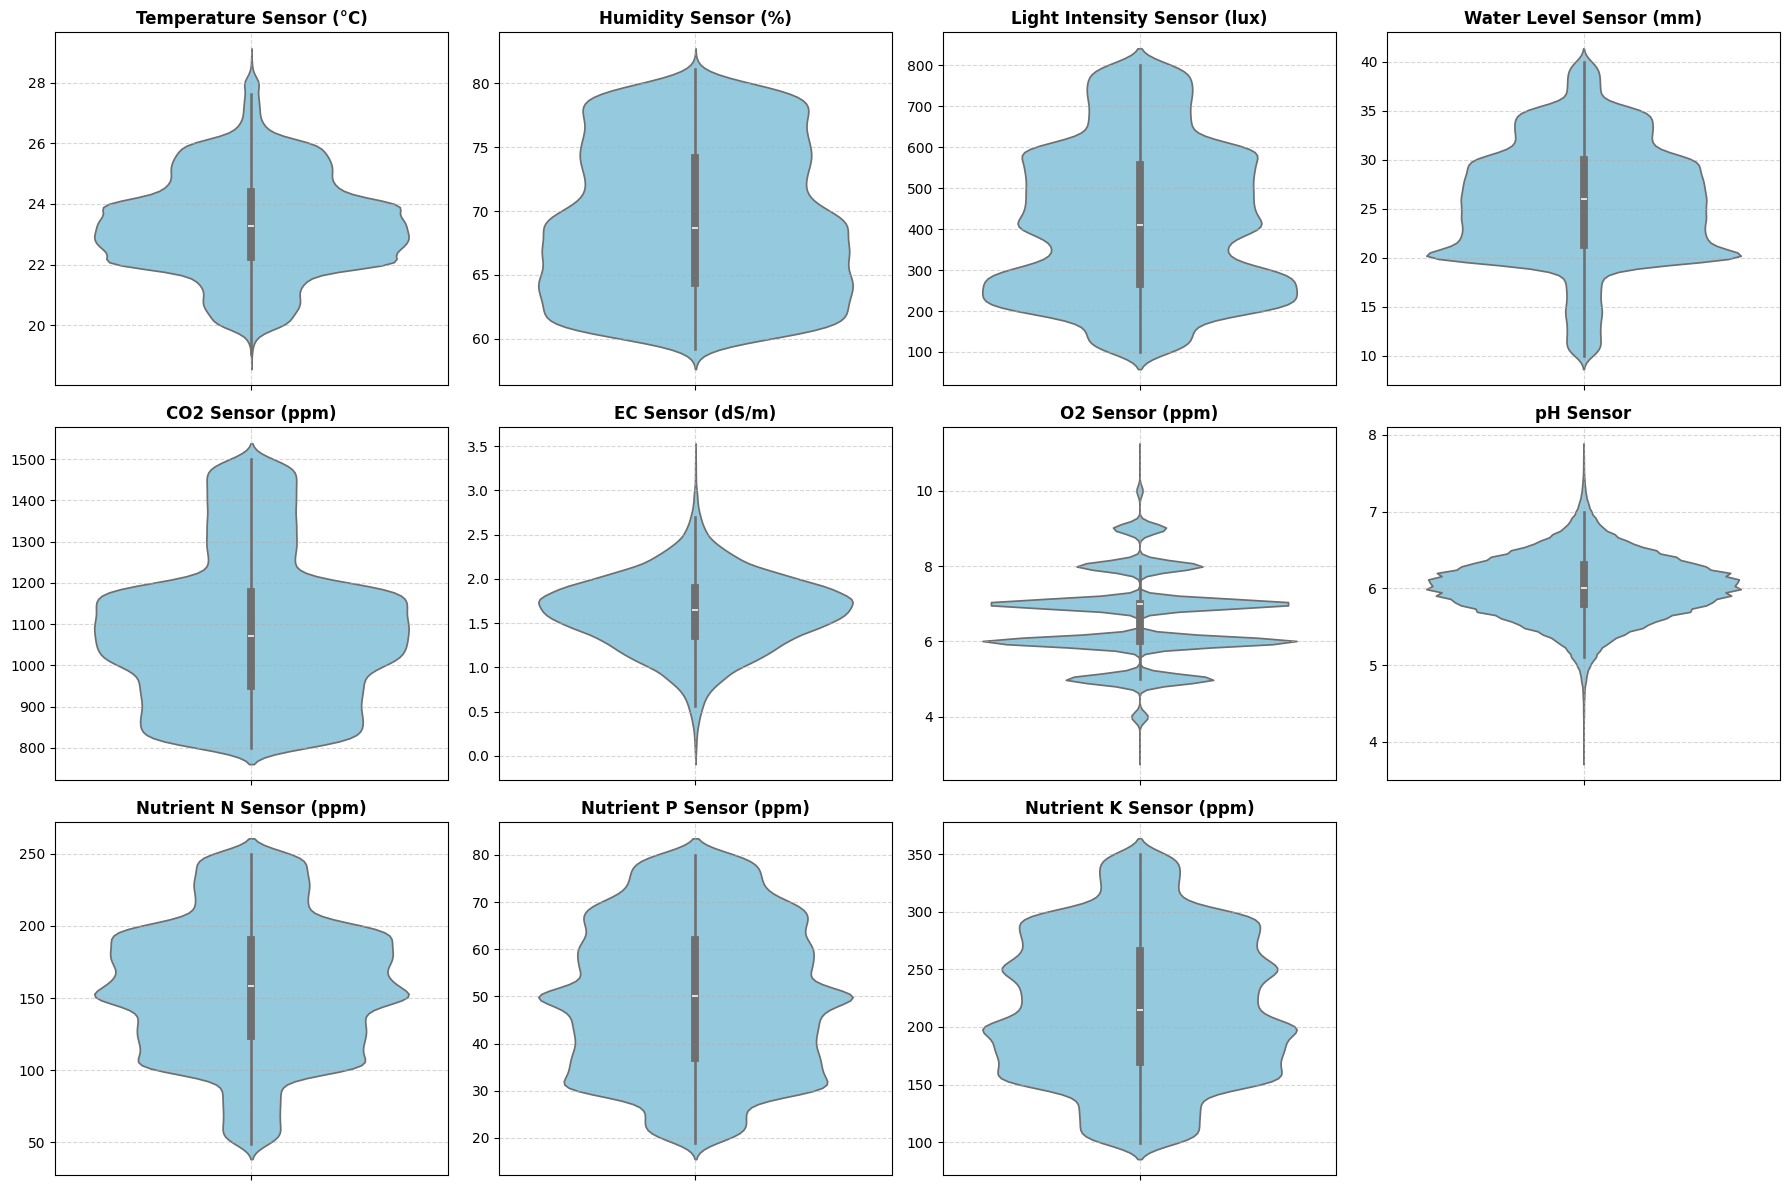

In [262]:
# Violin plots for each quantitative variable
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(quant_cols):
    sns.violinplot(y=df[col], ax=axes[i], color="skyblue", inner="box")
    axes[i].set_title(col, fontsize=12, fontweight="bold")
    axes[i].set_ylabel("")
    axes[i].grid(True, linestyle="--", alpha=0.5)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

# Section 4: Bivariate Analysis

### 4.1 Categorical Variables vs Temperature
Boxplots were used to examine the relationship between **categorical variables and temperature**. The results indicate that **System Location Code** and **Previous Cycle Plant Type** are not useful for modeling, as their distributions are nearly identical across categories. This suggests that they do not contribute meaningful variation to temperature and should be excluded to reduce complexity and noise.  

In contrast, **Plant Type** and **Plant Stage** exhibit clear patterns:  
- **Plant Type:** **Fruiting vegetables** tend to be associated with **higher temperatures**, while **leafy greens** are associated with **lower temperatures**.  
- **Plant Stage:** **Seedling stage** corresponds to **higher temperatures**, whereas the **vegetative stage** is associated with **lower temperatures**.  

Given these trends, **Plant Type and Plant Stage should be retained for modeling**, while **System Location Code and Previous Cycle Plant Type can be excluded** to improve model efficiency without sacrificing predictive power.  


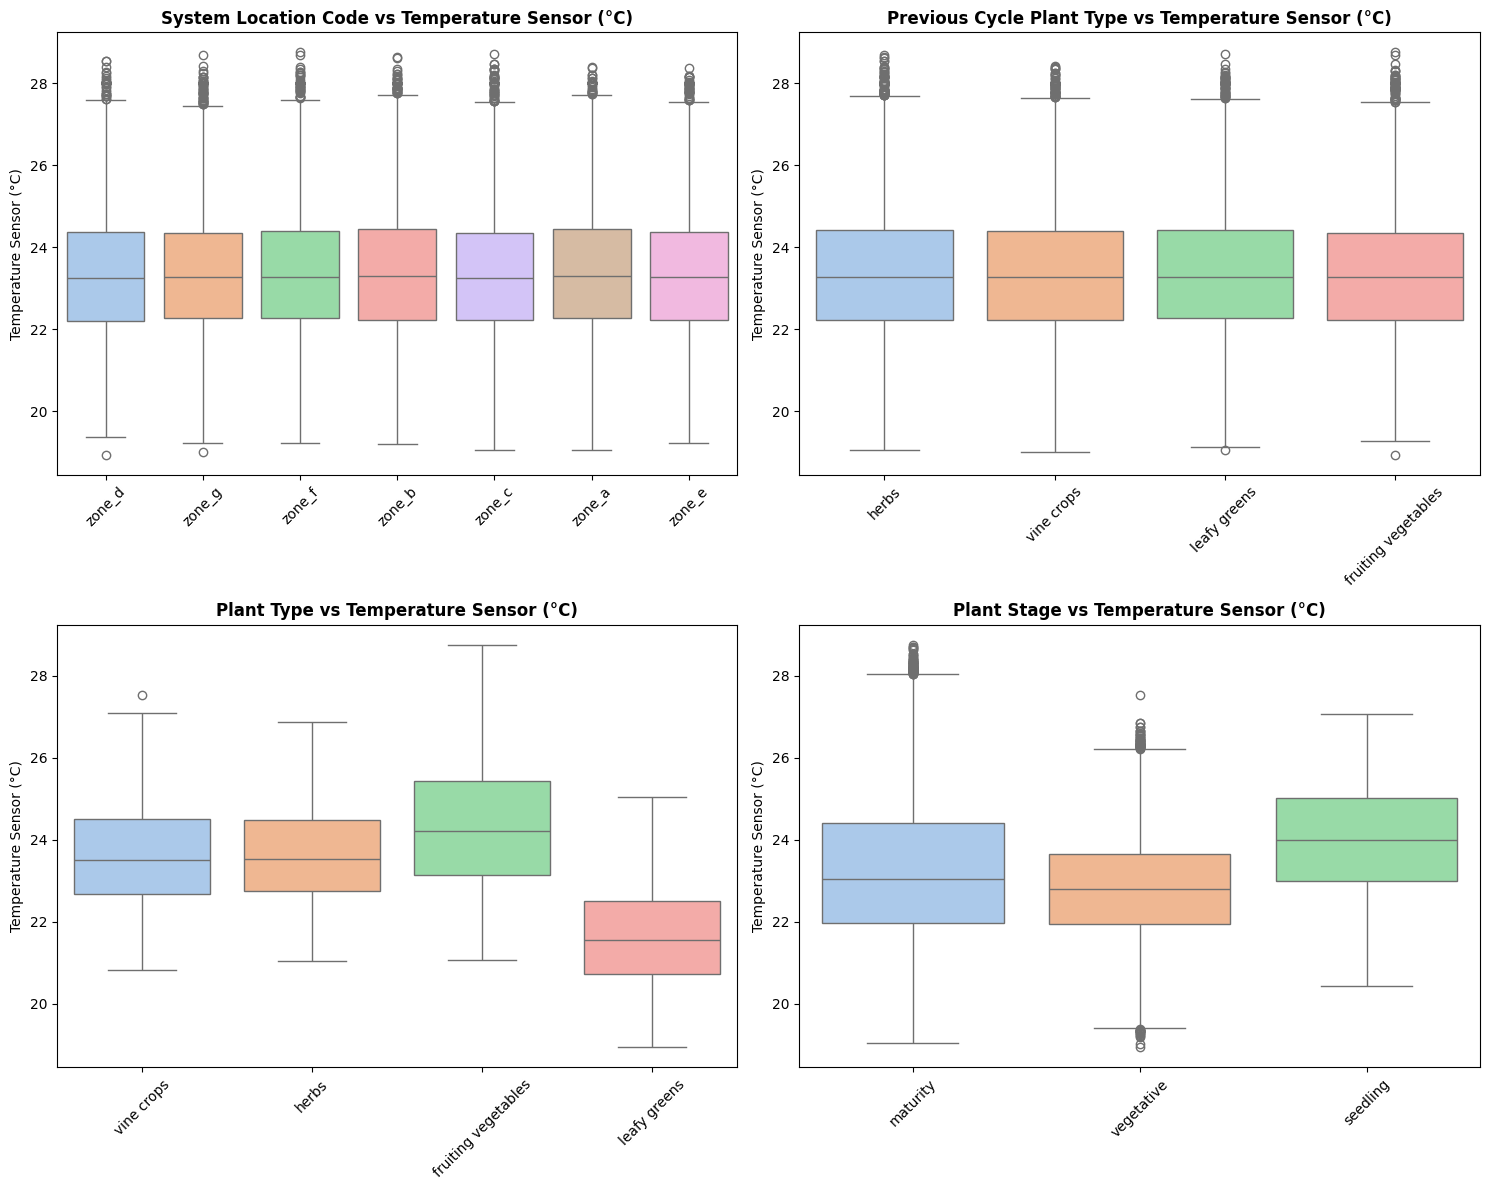

In [263]:
# Boxplots for temperature split by each categorical variable
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()
target_var = "Temperature Sensor (°C)"
for i, col in enumerate(cat_cols):
    sns.boxplot(x=df[col], y=df[target_var], ax=axes[i], hue=df[col], palette="pastel")
    axes[i].set_title(f"{col} vs {target_var}", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(target_var)
    axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

### 4.2 Quantitative Variables vs Temperature
A correlation matrix was formed to examine the relationship between quantitative variables and temperature. The results show that there are **no highly collinear features**, meaning there is no need to exclude any variables due to redundancy.  

Several variables exhibit **a mild correlation (r > 0.15) with temperature**, indicating they may be useful for modeling:  
- **Humidity Sensor (%)**  
- **Light Intensity Sensor (lux)**  
- **CO₂ Sensor (ppm)**  
- **Nutrient K Sensor (ppm)**  
- **Nutrient P Sensor (ppm)**  

These features could contribute to predicting temperature, as they show some level of association. The next section further explores these relationships visually through scatter plots.  

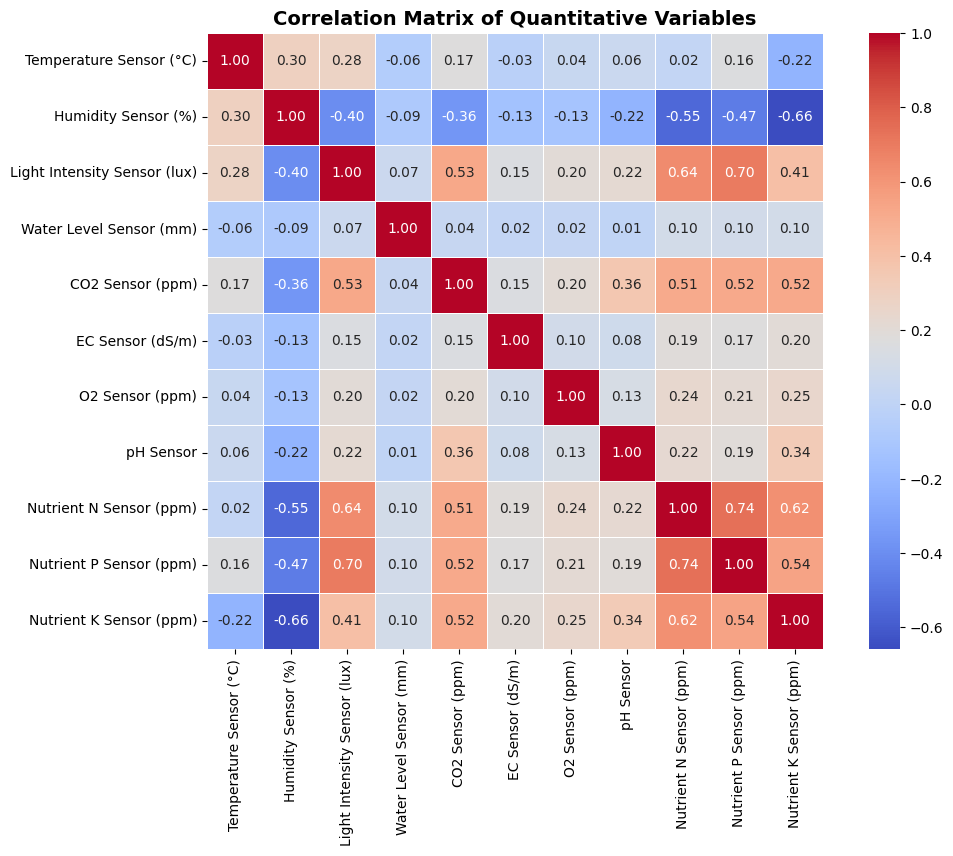

In [264]:
# Correlation matrix for every pair of quantitative variable
corr_matrix = df[quant_cols].dropna().corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Matrix of Quantitative Variables", fontsize=14, fontweight="bold")
plt.show()

Density scatter plots were generated to examine how each quantitative variable relates to temperature. The visualizations revealed that several variables exhibit **clustered density patterns**, where certain ranges of values for the feature variable tend to correspond to specific temperature ranges. This pattern suggests that temperature is not uniformly distributed across the full range of these features but instead follows distinct groupings.  

This phenomenon was observed in:  
- **Humidity Sensor (%)**  
- **Light Intensity Sensor (lux)**  
- **CO₂ Sensor (ppm)**  
- **Nutrient N Sensor (ppm)**  
- **Nutrient P Sensor (ppm)**  
- **Nutrient K Sensor (ppm)**  

To better capture these relationships, these features were **binned into meaningful ranges** based on their scatter plot patterns.  

Conversely, **Water Level Sensor (mm), EC Sensor (dS/m), O₂ Sensor (ppm), and pH Sensor** do not exhibit clear structured relationships with temperature. Their density scatter plots appear **elliptical**, indicating that these variables are at best midly correlated with temperature. These features could be considered for exclusion if the model becomes too complex.  

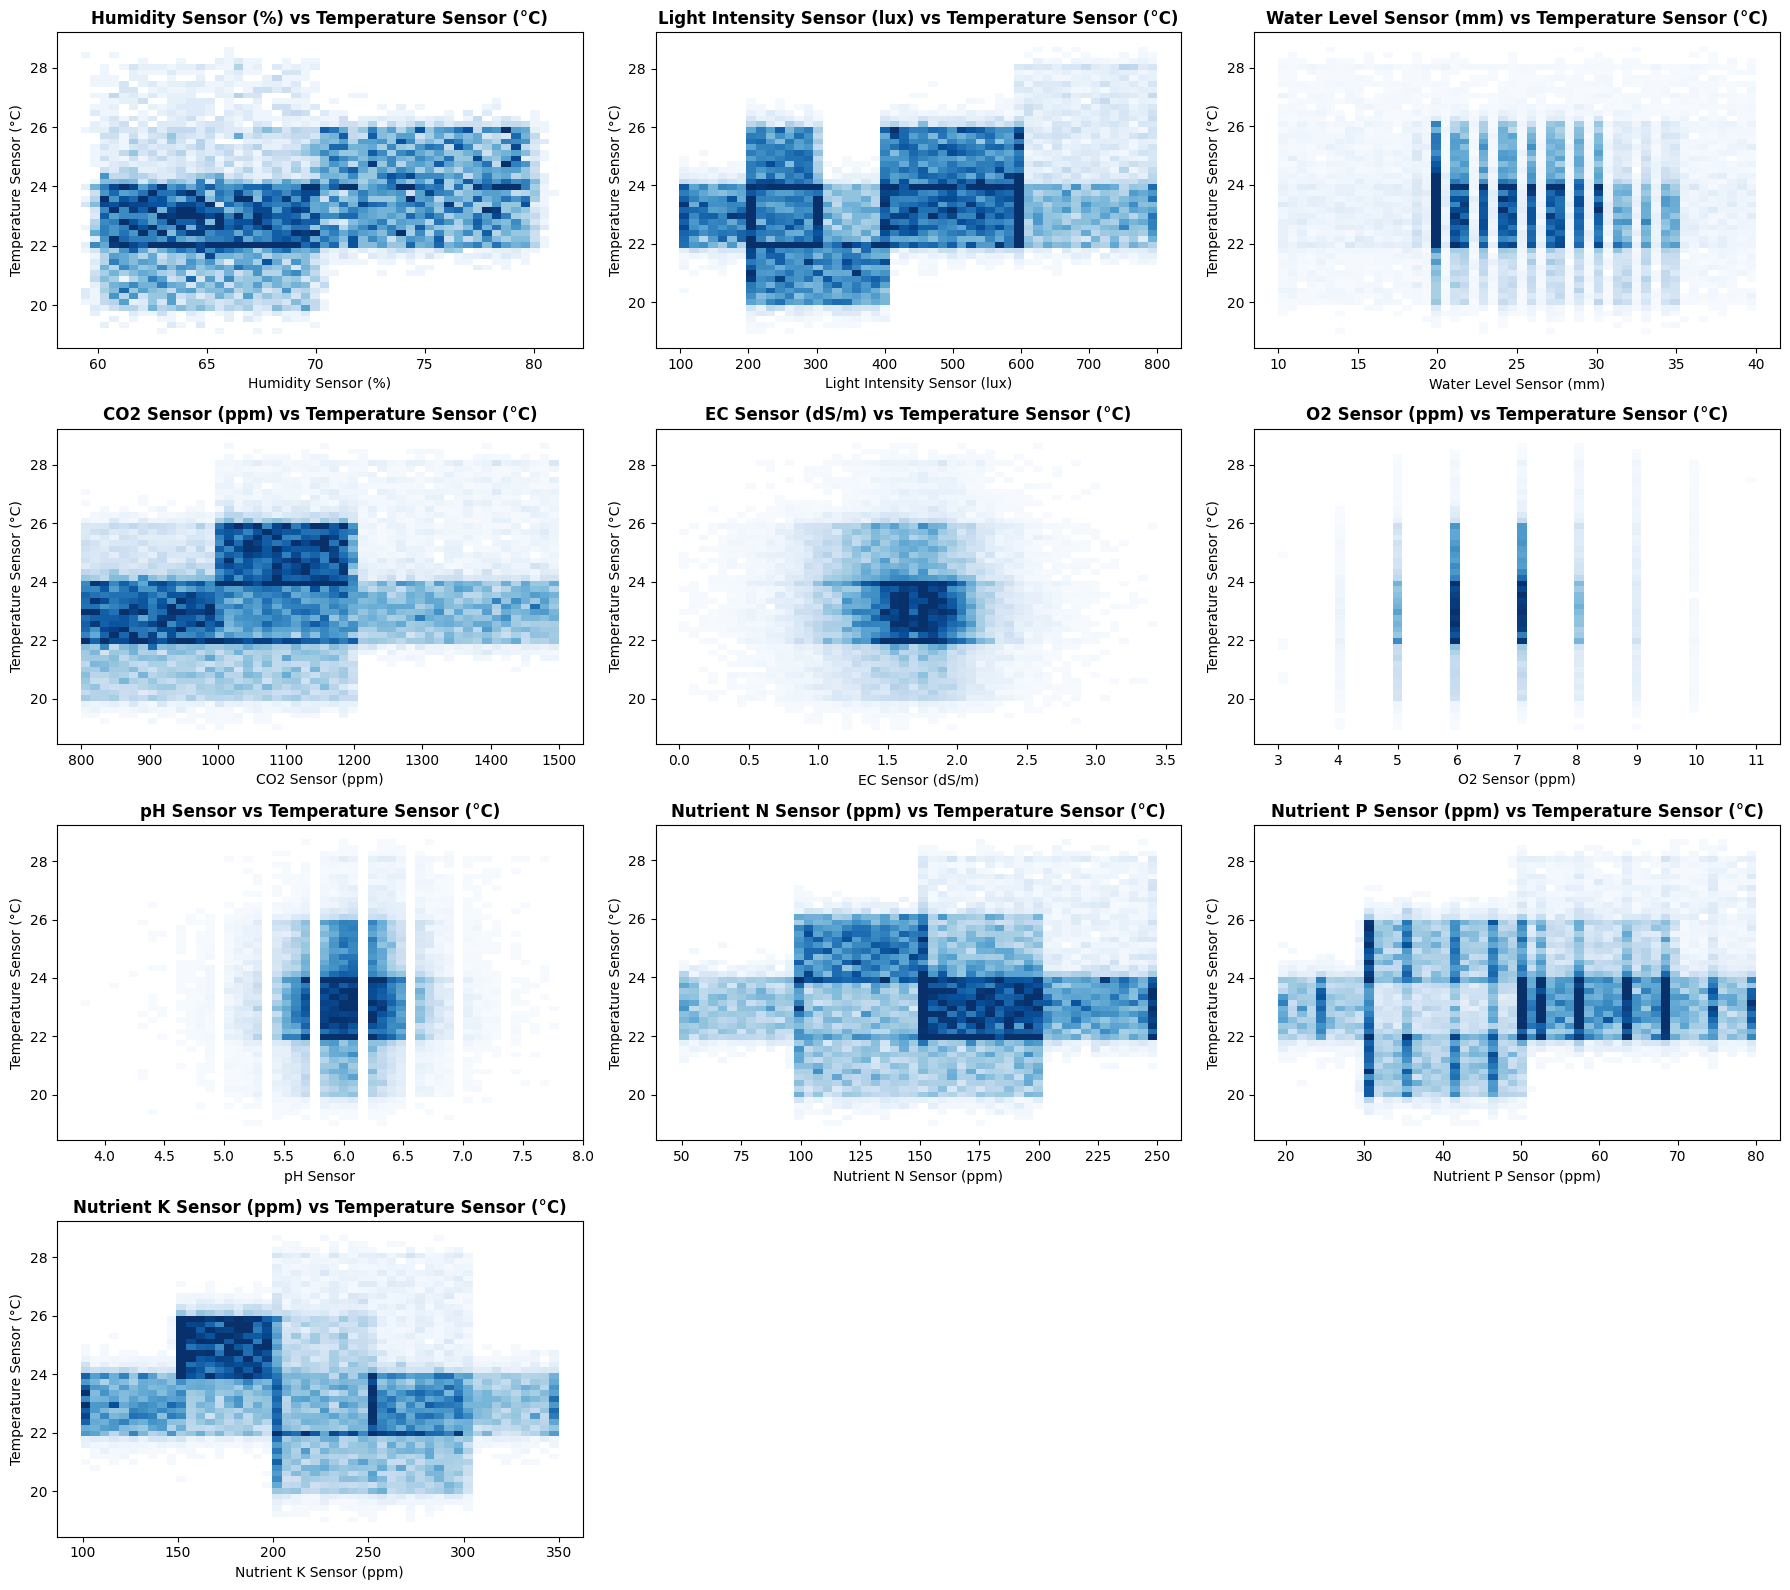

In [265]:
# Scatter density plots for each quantitative variable with temperature
quant_cols_excluding_temp = [col for col in quant_cols if col != "Temperature Sensor (°C)"]
target_var = "Temperature Sensor (°C)"
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.flatten()
for i, col in enumerate(quant_cols_excluding_temp):
    sns.histplot(x=df[col], y=df[target_var], ax=axes[i], 
                 bins=50, pmax=0.9, cmap="Blues")
    axes[i].set_title(f"{col} vs {target_var}", fontsize=12, fontweight="bold")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(target_var)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

Based on the density scatter plot analysis, we binned the **Humidity Sensor, Light Intensity Sensor, CO₂ Sensor, and Nutrient Sensor readings (N, P, K)** into meaningful groups. These bins were chosen based on observed patterns where certain ranges of values corresponded to distinct temperature distributions.  

The binning was performed as follows:  
- **Humidity Sensor (%):** Low `< 70`, High `≥ 70`  
- **Light Intensity Sensor (lux):** Low `< 200`, Medium `200 - 400`, High `> 400`  
- **CO₂ Sensor (ppm):** Low `< 1000`, Medium `1000 - 1200`, High `≥ 1200`  
- **Nutrient N Sensor (ppm):** Low `< 150`, High `≥ 150`  
- **Nutrient P Sensor (ppm):** Low `< 50`, High `≥ 50`  
- **Nutrient K Sensor (ppm):** Low `< 200`, High `≥ 200`  

Binning these features may help the model **better capture relationships** that might otherwise be difficult to learn from continuous values alone. To validate this approach, boxplots were generated to visualize the temperature distribution within each bin, providing clearer separations between different categories.  

In [266]:
# Humidity: 2 groups (Low < 70, High ≥ 70)
df["humidity_bin"] = df["Humidity Sensor (%)"].apply(lambda x: "Low" if pd.notna(x) and x < 70 else ("High" if pd.notna(x) else np.nan))

# Light Intensity: 3 groups (<200, 200-400, >400)
df["light_bin"] = pd.cut(df["Light Intensity Sensor (lux)"].dropna(), bins=[-float("inf"), 200, 400, float("inf")], 
                         labels=["Low", "Medium", "High"], include_lowest=True)

# CO2: 3 groups (<1000, 1000-1200, ≥1200)
df["co2_bin"] = pd.cut(df["CO2 Sensor (ppm)"].dropna(), bins=[-float("inf"), 1000, 1200, float("inf")], 
                        labels=["Low", "Medium", "High"], include_lowest=True)

# Nutrient N: 2 groups (Low < 150, High ≥ 150)
df["nutrient_n_bin"] = df["Nutrient N Sensor (ppm)"].apply(lambda x: "Low" if pd.notna(x) and x < 150 else ("High" if pd.notna(x) else np.nan))

# Nutrient P: 2 groups (Low < 50, High ≥ 50)
df["nutrient_p_bin"] = df["Nutrient P Sensor (ppm)"].apply(lambda x: "Low" if pd.notna(x) and x < 50 else ("High" if pd.notna(x) else np.nan))

# Nutrient K: 2 groups (Low < 200, High ≥ 200)
df["nutrient_k_bin"] = df["Nutrient K Sensor (ppm)"].apply(lambda x: "Low" if pd.notna(x) and x < 200 else ("High" if pd.notna(x) else np.nan))

Boxplots were generated to compare the temperature distribution across the newly created binned features. The visualizations show **clear distinctions** between the temperature ranges for each bin, confirming that the binning process effectively captures meaningful patterns in the data.  

Since the patterns are now more defined, these **binned features** should be included in the model instead of the original continuous quantitative columns. This transformation simplifies the data while preserving important relationships, potentially improving model interpretability and performance.  

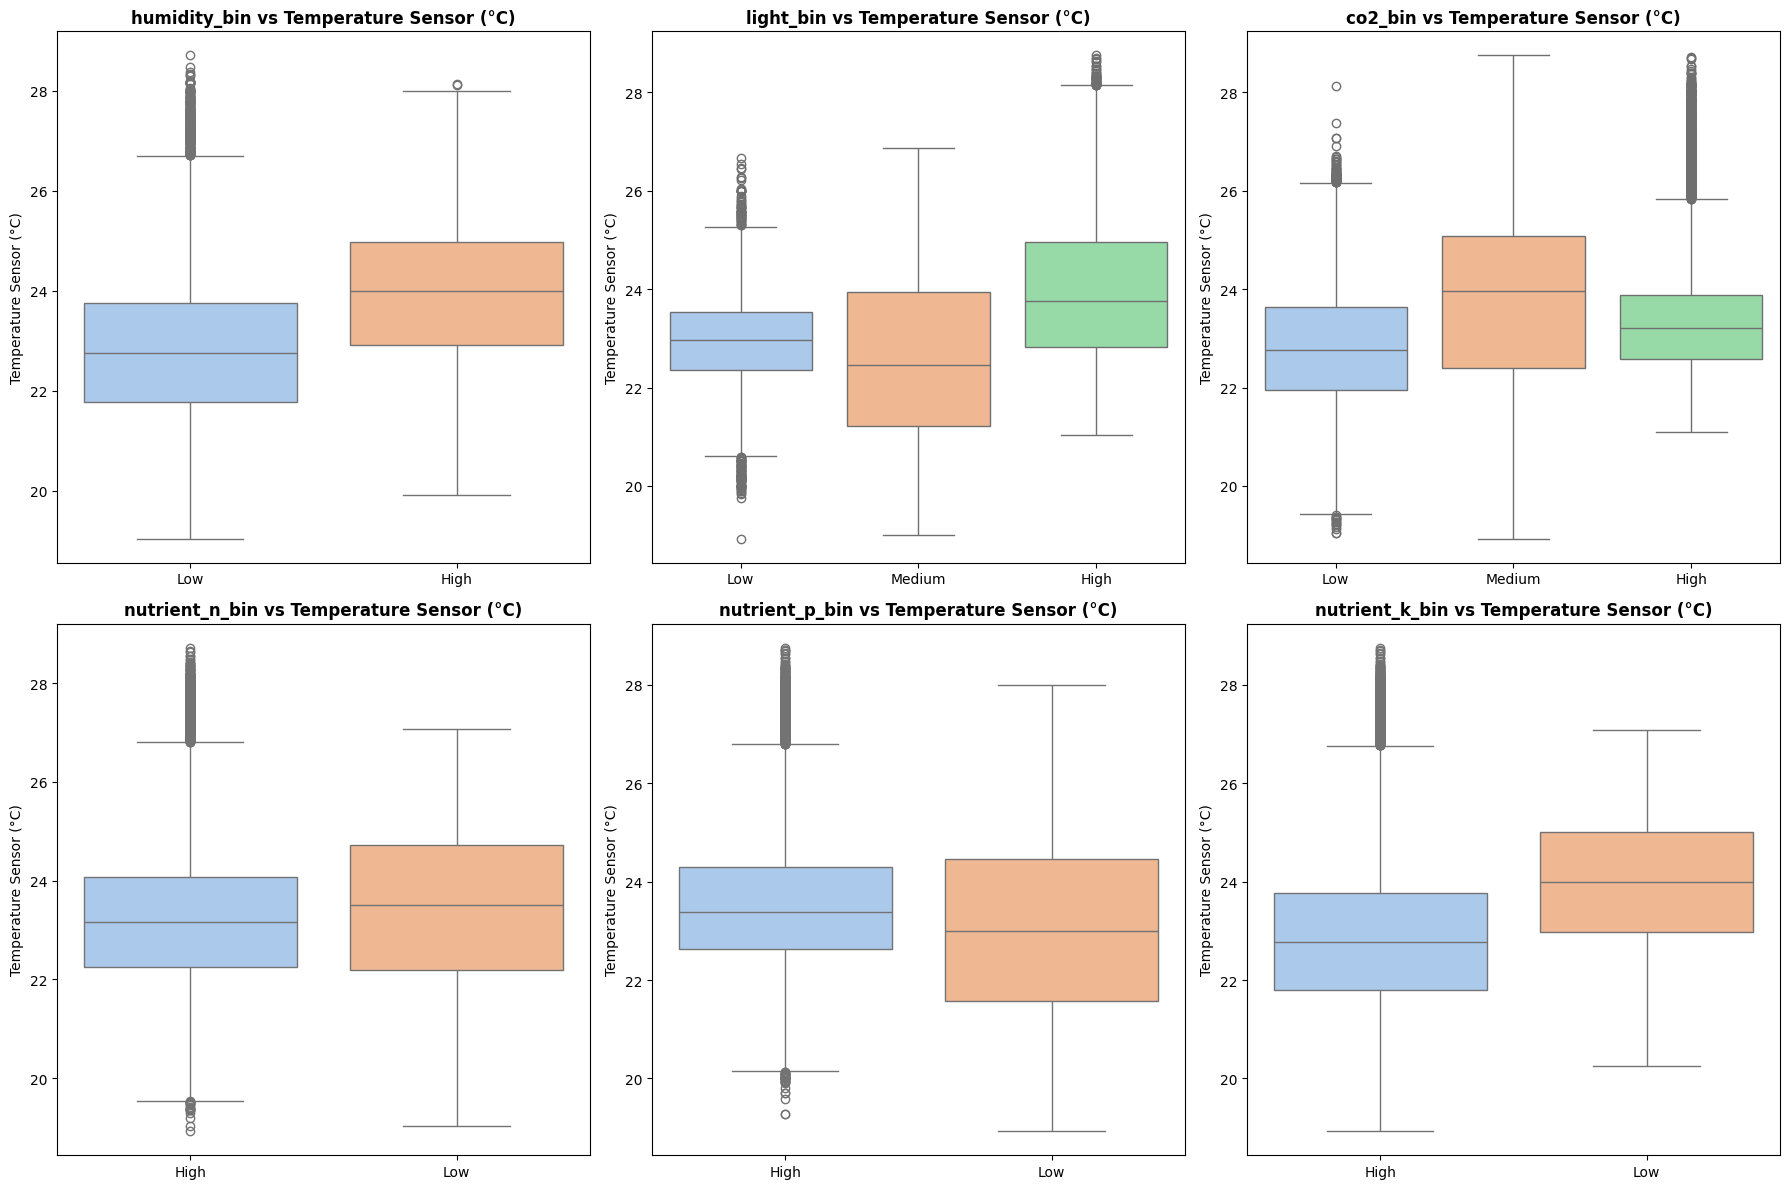

In [267]:
# Box plots for temperature split by binned quantitative features
binned_features = ["humidity_bin", "light_bin", "co2_bin", "nutrient_n_bin", "nutrient_p_bin", "nutrient_k_bin"]
target_var = "Temperature Sensor (°C)"
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()  # Flatten axes for easy iteration
for i, col in enumerate(binned_features):
    sns.boxplot(x=df[col], y=df[target_var], ax=axes[i], hue=df[col], palette="pastel", legend=False)
    axes[i].set_title(f"{col} vs {target_var}", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("")
    axes[i].set_ylabel(target_var)
plt.tight_layout()
plt.show()

# Section 5: Conclusion

Based on the exploratory data analysis (EDA), several key insights were derived that directly inform the machine learning pipeline and feature engineering decisions. 

- **Categorical Variables**: Variables such as **Plant Type** and **Plant Stage** exhibited clear patterns with temperature, making them crucial for the model. These features were retained and one-hot encoded. On the other hand, **System Location Code** and **Previous Cycle Plant Type** were excluded due to their lack of predictive power.

- **Quantitative Variables**: The analysis revealed several features with mild correlations to temperature, including **Humidity Sensor (%), Light Intensity Sensor (lux), CO₂ Sensor (ppm), and Nutrient Sensors (N, P, K)**. These features were retained for the model due to their potential to help predict temperature.

- **Binning Strategy**: Features like **Humidity**, **Light Intensity**, **CO₂**, and **Nutrient Sensors** exhibited distinct groupings when plotted against temperature. These features were binned into meaningful categories to better capture temperature relationships. The binning process resulted in clearer distinctions in temperature distributions, making these binned features suitable for model training.

- **Exclusion of Features**: Some variables, such as **Water Level Sensor (mm), EC Sensor (dS/m), O₂ Sensor (ppm), and pH Sensor**, showed minimal correlation with temperature and could be considered for exclusion from the modeling process to reduce model complexity.

Overall, the feature engineering choices based on the EDA provide a robust foundation for the machine learning pipeline, focusing on the most relevant features while simplifying the data for better model interpretability and performance.
